In [60]:
import pandas as pd

nifty100_df = pd.read_csv('nifty100.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty100_df.Symbol.tolist()]

In [61]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

Loading 1Dmin data: 100%|██████████| 100/100 [00:00<00:00, 363.59it/s]


In [62]:
ohlc_dict = {
    'Open': 'first',
    'Low': 'min',
    'High': 'max',
    'Close': 'last',
}

df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()
# df = df[df.Date >= '2020-01-01'].reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index(['Stock', 'Date']).sort_index()
df = df.groupby('Stock').resample('MS', on='Date').agg(ohlc_dict)

In [63]:
df['entry_price'] = df.groupby('Stock')['Open'].shift(-1)
df['exit_price'] = df.groupby('Stock')['Close'].shift(-1)
df['max_low'] = df.groupby('Stock')['Low'].shift(-1)
df['max_high'] = df.groupby('Stock')['High'].shift(-1)
df['returns'] = df.groupby('Stock')['Close'].diff()
df['returns_perc'] = df.groupby('Stock')['Close'].pct_change()
df['next_month_returns'] = df.groupby('Stock')['returns'].shift(-1)
df['next_month_returns_perc'] = df.groupby('Stock')['returns_perc'].shift(-1)

In [64]:
def get_returns(_df, months):
    return _df.groupby('Stock')['Close'].transform(lambda x: x.pct_change(months)).dropna()

returns_12m = get_returns(df, 12)
start_date = returns_12m.index.get_level_values(1)[0]

returns_6m = get_returns(df, 6)
returns_6m = returns_6m[returns_6m.index.get_level_values(1) >= start_date]

returns_3m = get_returns(df, 3)
returns_3m = returns_3m[returns_3m.index.get_level_values(1) >= start_date]

In [65]:
def top_n(_df, n, mask=None):
    dfs = []
    for idx, row in _df.groupby('Date'):
        date_mask = []
        if mask is not None:
            date_mask = mask.loc[idx].index.tolist()
            dfs.append(row.loc[date_mask].nlargest(n))
        else:
            dfs.append(row.nlargest(n))
    return pd.concat(dfs)

top_50 = top_n(returns_12m, 50)
top_30 = top_n(returns_6m, 30, top_50.swaplevel('Stock', 'Date').sort_index())
top_10 = top_n(returns_3m, 10, top_30.swaplevel('Stock', 'Date').sort_index())
top_10 = top_10.swaplevel('Stock', 'Date').sort_index()

In [66]:
from lib import Bank, PositionManager

initial_capital = 500000
leverage = 1


def backtest(pm: PositionManager):
    data = df[df.index.get_level_values(1) >= start_date].dropna(subset=['entry_price', 'exit_price'])
    for idx, group in data.groupby('Date'):
        date = idx
        selected_stocks = top_10.loc[date].index.tolist()
        capital = pm.bank.balance()
        capital_split = capital / len(selected_stocks)
        for s in selected_stocks:
            d = group.loc[(s, date)]
            position = pm.new_position(s, date, d['entry_price'], capital_split)
            # if d.max_low <= position.sl:
            #     pm.close_position(s, date, position.sl)
            # elif d.max_high >= position.tp:
            #     pm.close_position(s, date, position.tp)
            # else:
            pm.close_position(s, date, d['exit_price'])

if __name__ == "__main__":
    bank = Bank(initial_capital, number_of_buckets=1)
    pm = PositionManager(bank, leverage=leverage)
    backtest(pm)

In [67]:
from dataclasses import  asdict
trades = pd.DataFrame([asdict(p) for p in pm.closed_positions]).sort_values(['entry_time']).reset_index(drop=True)#.to_csv(f'{root_path}/closed_positions.csv', index=False)

In [68]:
import pandas as pd
from datetime import datetime

# Ensure entry_time and exit_time are datetime
trades['entry_time'] = pd.to_datetime(trades['entry_time'])
trades['exit_time'] = pd.to_datetime(trades['exit_time'])

# Total trades
total_trades = len(trades)

# Win rate
win_trades = (trades['pnl'] > 0).sum()
win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

# Total profit
total_profit = trades['pnl'].sum() - trades['tax'].sum()

# Total tax
total_tax = trades['tax'].sum()

# MTF charge
total_mtf_charge = trades['mtf_charge'].sum()

# CAGR calculation
start = trades['entry_time'].min()
end = trades['exit_time'].max()
years = (end - start).days / 365.25
initial = initial_capital  # initial_capital from your code
final = initial + total_profit
cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

# Active positions
active_position_count = sum([len(p.trades) for p in pm.get_active_positions() if p is not None])

# Period
period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

# Max holding period
max_holding_period = (trades['exit_time'] - trades['entry_time']).max().days
avg_holding_period = (trades['exit_time'] - trades['entry_time']).mean().days

# Final capital
final_capital = initial + total_profit


# Calculate drawdown
trades['cum_pnl'] = trades['pnl'].cumsum()

trades['cum_max'] = trades['cum_pnl'].cummax()
trades['drawdown'] = trades['cum_pnl'] - trades['cum_max']
max_drawdown = trades['drawdown'].min()
max_drawdown_pct = abs(max_drawdown) / trades['cum_max'].max() * 100 if trades['cum_max'].max() != 0 else 0

number_of_losses = len(trades[trades['pnl'] < 0])
number_of_wins = len(trades[trades['pnl'] > 0])
profit_factor = trades[trades['pnl'] > 0]['pnl'].sum() / abs(trades[trades['pnl'] < 0]['pnl'].sum()) if abs(trades[trades['pnl'] < 0]['pnl'].sum()) > 0 else None

# Tearsheets summary
tearsheet = pd.DataFrame({
    'Metric': [
        'Period',
        'Final capital',
        'Total Trades',
        'Winners',
        'Losers',
        'Profit factor',
        'Active Position Count',
        'Max holding period (days)',
        'Avg holding period (days)',
        'Win Rate (%)',
        'Total Profit',
        'Total Tax',
        'Total MTF',
        'CAGR (%)',
        'Max Drawdown (%)'
    ],
    'Value': [
        period,
        f"{final_capital:.2f}",
        f"{total_trades:,}",
        f"{number_of_wins:,}",
        f"{number_of_losses:,}",
        f"{profit_factor:.2f}" if profit_factor else "N/A",
        f"{active_position_count:,}",
        f"{max_holding_period:,}",
        f"{avg_holding_period:,}",
        f"{win_rate:.2f}",
        f"{total_profit:,.2f}",
        f"{total_tax:.2f}" if total_tax else "N/A",
        f"{total_mtf_charge:.2f}" if total_mtf_charge else "N/A",
        f"{cagr:.2f}" if cagr else "N/A",
        f"{max_drawdown_pct:,.2f}"
    ]
})

tearsheet

,Metric,Value
0,Period,2016-01-01 to 2025-07-01
1,Final capital,4318589.33
2,Total Trades,"1,150"
3,Winners,641
4,Losers,509
5,Profit factor,1.62
6,Active Position Count,0
7,Max holding period (days),0
8,Avg holding period (days),0
9,Win Rate (%),55.74


<Axes: title={'center': 'Cumulative PnL vs Exit Time'}, xlabel='exit_time'>

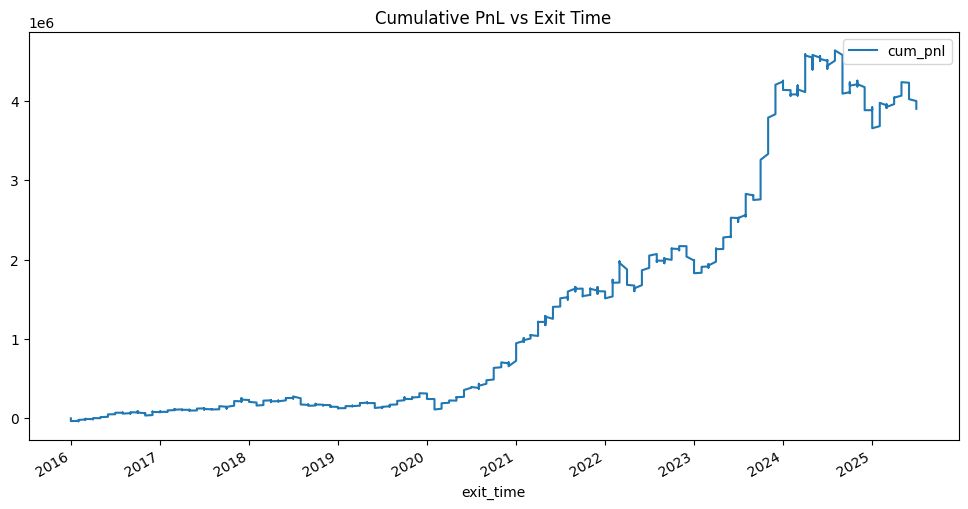

In [69]:
# ...existing code...
trades = trades.sort_values(['exit_time']).reset_index(drop=True)
trades['cum_pnl'] = trades['pnl'].cumsum()
trades.plot(x='exit_time', y='cum_pnl', title='Cumulative PnL vs Exit Time', figsize=(12, 6))

In [70]:
losses = trades[trades.pnl < 0]
losses['returns_perc'] = (losses.exit_price - losses.avg_entry_price)/losses.avg_entry_price * 100
losses.sort_values(by=["returns_perc"])
losses[losses.returns_perc < -10]

/var/folders/rw/xc9yc4151v3_3lcv8h2n7pxr0000gn/T/ipykernel_37346/3705299958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses['returns_perc'] = (losses.exit_price - losses.avg_entry_price)/losses.avg_entry_price * 100


,stock,entry_time,avg_entry_price,last_entry_price,quantity,exit_time,exit_price,tp,sl,trades,...,mtf_charge,leverage,mtf_rate_daily,tp_perc,sl_perc,max_mtf_days,cum_pnl,cum_max,drawdown,returns_perc
2,NSE:GAIL-EQ,2016-01-01,69.00,69.00,724,2016-01-01,57.22,69.6900,68.3100,"[{'capital_key': '6ec18060', 'entry_time': 201...",...,0.0,1,0.000192,1,1,100,-10240.07,-598.95,-9641.12,-17.072464
4,NSE:INDHOTEL-EQ,2016-01-01,104.77,104.77,477,2016-01-01,91.86,105.8177,103.7223,"[{'capital_key': '6ec18060', 'entry_time': 201...",...,0.0,1,0.000192,1,1,100,-21178.94,-598.95,-20579.99,-12.322230
6,NSE:POWERGRID-EQ,2016-01-01,83.40,83.40,599,2016-01-01,73.34,84.2340,82.5660,"[{'capital_key': '6ec18060', 'entry_time': 201...",...,0.0,1,0.000192,1,1,100,-23129.68,-598.95,-22530.73,-12.062350
11,NSE:APOLLOHOSP-EQ,2016-02-01,1479.00,1479.00,31,2016-02-01,1329.30,1493.7900,1464.2100,"[{'capital_key': '6ec18060', 'entry_time': 201...",...,0.0,1,0.000192,1,1,100,-37976.56,-598.95,-22544.91,-10.121704
73,NSE:JINDALSTEL-EQ,2016-08-01,85.95,85.95,661,2016-08-01,75.95,86.8095,85.0905,"[{'capital_key': '6ec18060', 'entry_time': 201...",...,0.0,1,0.000192,1,1,100,63163.93,69908.49,-10906.43,-11.634671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,NSE:NAUKRI-EQ,2024-12-01,1737.59,1737.59,267,2024-12-01,1544.74,1754.9659,1720.2141,"[{'capital_key': '6ec18060', 'entry_time': 202...",...,0.0,1,0.000192,1,1,100,3893823.08,4726188.23,-561757.30,-11.098706
1085,NSE:INFY-EQ,2025-01-01,1880.30,1880.30,229,2025-01-01,1687.70,1899.1030,1861.4970,"[{'capital_key': '6ec18060', 'entry_time': 202...",...,0.0,1,0.000192,1,1,100,3826399.24,4726188.23,-1051141.40,-10.243046
1086,NSE:M&M-EQ,2025-01-01,2990.00,2990.00,144,2025-01-01,2585.10,3019.9000,2960.1000,"[{'capital_key': '6ec18060', 'entry_time': 202...",...,0.0,1,0.000192,1,1,100,3768093.64,4726188.23,-1007036.00,-13.541806
1088,NSE:TECHM-EQ,2025-01-01,1674.50,1674.50,257,2025-01-01,1487.85,1691.2450,1657.7550,"[{'capital_key': '6ec18060', 'entry_time': 202...",...,0.0,1,0.000192,1,1,100,3707029.34,4726188.23,-935635.15,-11.146611
